# Supplier Price Analysis for Strategic Procurement

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Reading the dataset from the directory

prices = pd.read_csv("article_prices.csv/article_prices.csv")
prices.head()

,product,offer,supplier,tier,price
0,1,1,1498,1.0,24.12
1,1,2,1690,1.0,24.14
2,1,2,1690,5.0,24.10
3,1,3,1955B,1.0,26.00
4,1,3,1955B,2.0,25.87


### Understanding the distribution of products among different suppliers

In [6]:
supplier_list = prices['supplier'].unique()
for i in supplier_list:
    df1 = prices.loc[prices['supplier']==i, ['product']]
    unique_products = len(np.unique(df1.values.ravel()))
    print(f'The supplier {i} has {unique_products} unique products out of 777. So there are {777-unique_products} products missing')

The supplier 1498 has 760 unique products out of 777. So there are 17 products missing
The supplier 1690 has 731 unique products out of 777. So there are 46 products missing
The supplier 1955B has 776 unique products out of 777. So there are 1 products missing
The supplier 2478B has 760 unique products out of 777. So there are 17 products missing
The supplier 4757 has 777 unique products out of 777. So there are 0 products missing
The supplier 5417B has 449 unique products out of 777. So there are 328 products missing
The supplier 5766 has 734 unique products out of 777. So there are 43 products missing
The supplier 9587 has 776 unique products out of 777. So there are 1 products missing
The supplier 2627A has 8 unique products out of 777. So there are 769 products missing


### Methodology:
- Volume Discount Analysis
- Comprehensive Supplier Coverage

In [24]:
# Define the quantities of interest for which we want to compare prices
quantities = [1, 3, 5, 10, 20, 50, 100, 200, 500, 1000]

def get_min_prices(df, quantities):
    results = pd.DataFrame()
    for quantity in quantities:
        # Filter the DataFrame for the current quantity or less
        df_filtered = df[df['tier'] <= quantity]
        
        # Obtain the minimum price for each product at or below this tier
        min_prices = df_filtered.groupby('product').agg({'price': 'min'}).reset_index()
        min_prices.rename(columns={'price': f'price_at_{quantity}'}, inplace=True)
        
        # Merge back to get supplier info
        df_merged = pd.merge(df_filtered, min_prices, how='inner', left_on=['product', 'price'], right_on=['product', f'price_at_{quantity}'])
        
        # Select only relevant columns to avoid duplication
        df_merged = df_merged[['product', 'supplier', f'price_at_{quantity}']].drop_duplicates()
        
        # Merge with results DataFrame
        if results.empty:
            results = df_merged
        else:
            results = pd.merge(results, df_merged, on=['product', 'supplier'], how='outer')

    return results

# Calculate the minimum prices for each quantity and merge the results
min_price_data = get_min_prices(prices, quantities)

# Count how often each supplier offers the minimum price
supplier_scores = min_price_data.melt(id_vars=['product', 'supplier'], value_vars=[f'price_at_{q}' for q in quantities])
supplier_scores = supplier_scores.dropna(subset=['value']).groupby('supplier').size().reset_index(name='counts')
supplier_scores = supplier_scores.sort_values(by='counts', ascending=False)


# Print the results
# print('Minimum price data')
# print('-------------------')
# print(min_price_data.head())
# print('-------------------')
print('Final count of suppliers with minimum price')
print('--------------------------------------------')
print(supplier_scores)

Final count of suppliers with minimum price
--------------------------------------------
  supplier  counts
1     1690    3009
0     1498    1813
6    5417B     968
5     4757     656
2    1955B     344
8     9587     311
3    2478B     309
7     5766     133
4    2627A      64


### Result Interpretation

This list of supplier counts with minimum prices tells which supplier provides the most competitive prices across a range of purchase quantites and how often they offer the lowest prices. This helps __Unite__ in guiding decisions on where to potentially strengthen supplier relationships

In [8]:
# Get a better view of the intermediate result of minimum price calculation function
min_price_data

,product,supplier,price_at_1,price_at_3,price_at_5,price_at_10,price_at_20,price_at_50,price_at_100,price_at_200,price_at_500,price_at_1000
0,1,5417B,21.94,21.94,21.94,21.15,21.15,20.08,20.08,20.08,20.08,20.08000
1,2,5417B,74.34,72.83,72.53,69.11,69.11,69.11,69.11,69.11,69.11,69.11000
2,3,5417B,95.80,93.92,93.59,89.17,89.17,89.17,89.17,89.17,89.17,89.17000
3,4,5417B,2.48,2.19,2.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5417B,3.29,3.29,2.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1129,114,4757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.48000
1130,133,1955B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02539
1131,302,2478B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.09000
1132,532,2478B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.05000


### Code Insights

- __Get minimum price function__: A function to determine the lowest price for different quantites
    1. __Filter Data__: For each quantity, filter the data for products where the tier is less than or equal to the specified quantity
    2. __Find Minimum Prices__: Determine the minimum price for each product for the specific tier (quantity).
    3. __Merge Supplier Information__: Merge back to include the supplier information.
    4. __Compile Results Across Quantities__: Combine results across all quantities to see a comprehensive view.
    
    
    
- The __dataframe.melt()__:

    - This function is used for filtering and analysis. It helps in transforming the wide format to long format. The idea is to have one row for each price point per product per supplier, which makes it easier to analyze or filter based on quantites.
    
    - This helps in finding the lowest price for each product across all quantities, or analyze pricing trends for a supplier across different quantities. This format is especially useful in scenarios like the use case, where comparing pricing across multiple conditions (like different quantities) is crucial.

## Insights and Visualizations

### Part 1: Volume Discount Analysis

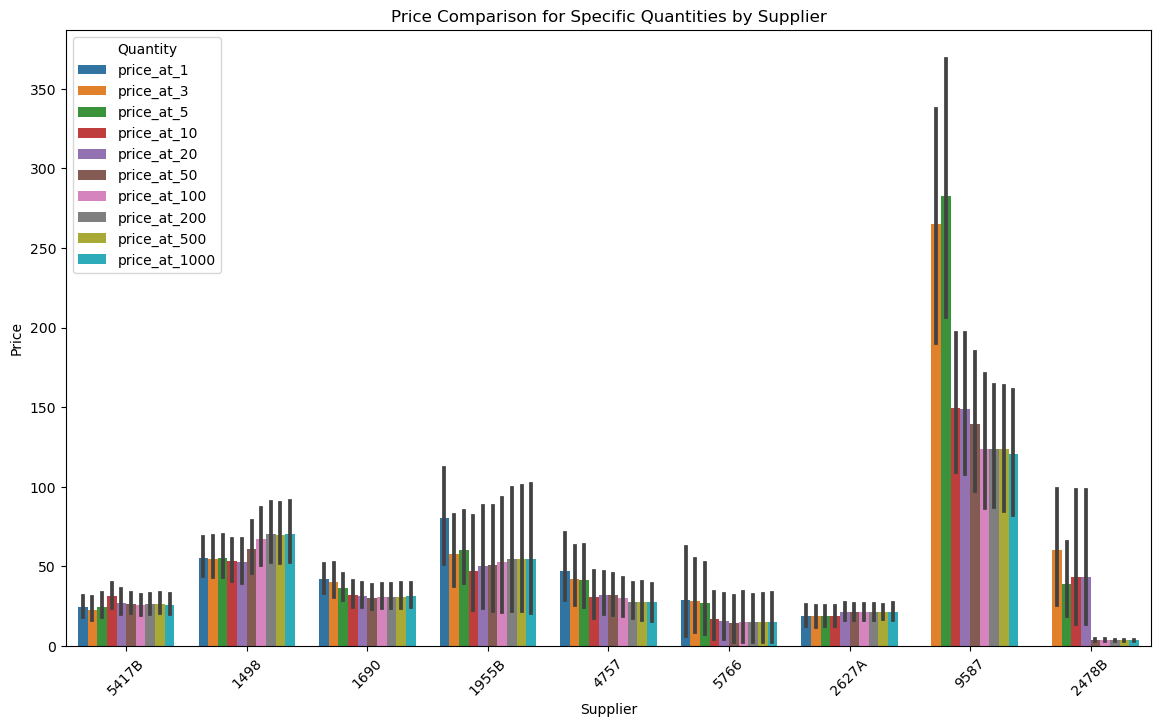

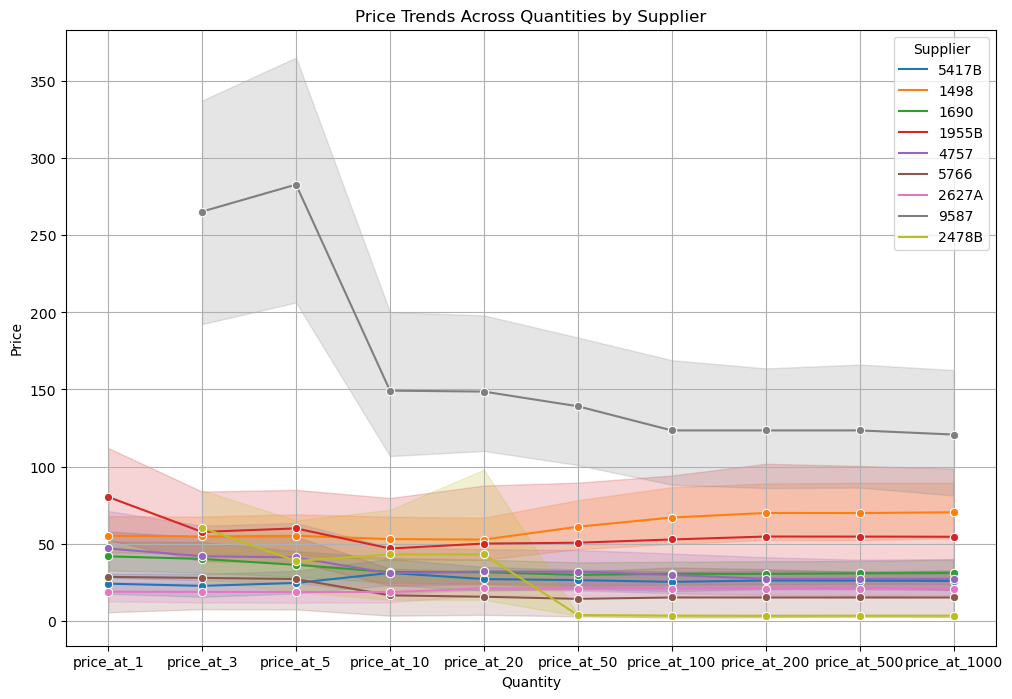

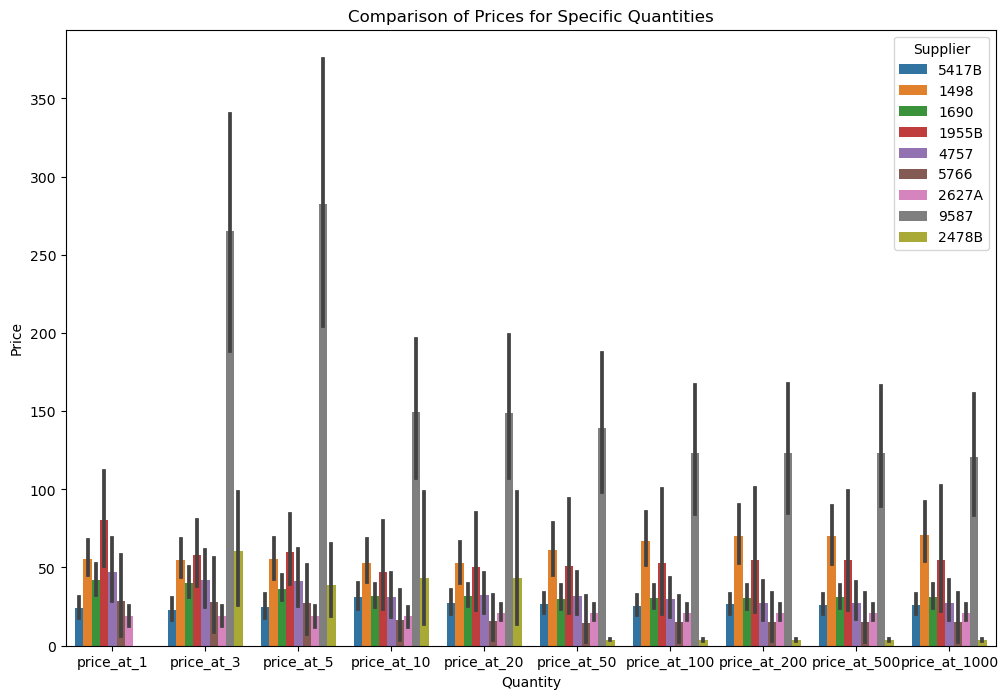

In [13]:
# Visualization 1: Comparison of suppliers for different quantites
def plot_price_comparison(data):
    specific_data = data[['supplier'] + [f'price_at_{q}' for q in quantities]]
    melted_data = specific_data.melt(id_vars=['supplier'], var_name='quantity', value_name='price')
    plt.figure(figsize=(14, 8))
    sns.barplot(data=melted_data, x='supplier', y='price', hue='quantity')
    plt.title('Price Comparison for Specific Quantities by Supplier')
    plt.xlabel('Supplier')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.legend(title='Quantity')
    plt.savefig("Price_Comaprison_for_specific_quantites")
    plt.show()
    

# Visualization 2: Line graph for price comparison for Specific Quantities
def plot_price_trends(data):
    melted_data = data.melt(id_vars=['product', 'supplier'], var_name='quantity', value_name='price')
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=melted_data, x='quantity', y='price', hue='supplier', marker='o')
    plt.title('Price Trends Across Quantities by Supplier')
    plt.xlabel('Quantity')
    plt.ylabel('Price')
    plt.legend(title='Supplier', loc='upper right')
    plt.grid(True)
    plt.show()


# Visualization 3: Bar graph for the same price Comparison for Specific Quantities
def plot_specific_quantities(data, quantities):
    specific_data = data[['supplier'] + [f'price_at_{q}' for q in quantities]]
    melted_data = specific_data.melt(id_vars=['supplier'], var_name='quantity', value_name='price')
    plt.figure(figsize=(12, 8))
    sns.barplot(data=melted_data, x='quantity', y='price', hue='supplier')
    plt.title('Comparison of Prices for Specific Quantities')
    plt.xlabel('Quantity')
    plt.ylabel('Price')
    plt.legend(title='Supplier', loc='upper right')
    plt.savefig("Price_Comparison_for_Specific_Qunatities")
    plt.show()

# Execute plotting functions
plot_price_comparison(min_price_data)
plot_price_trends(min_price_data)
plot_specific_quantities(min_price_data, quantities)

### Part 2: Supplier Coverage Analysis

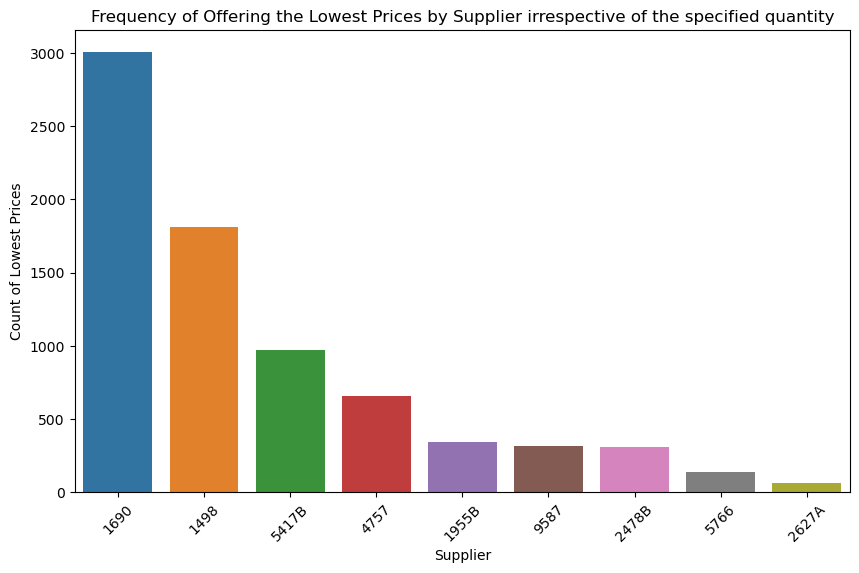

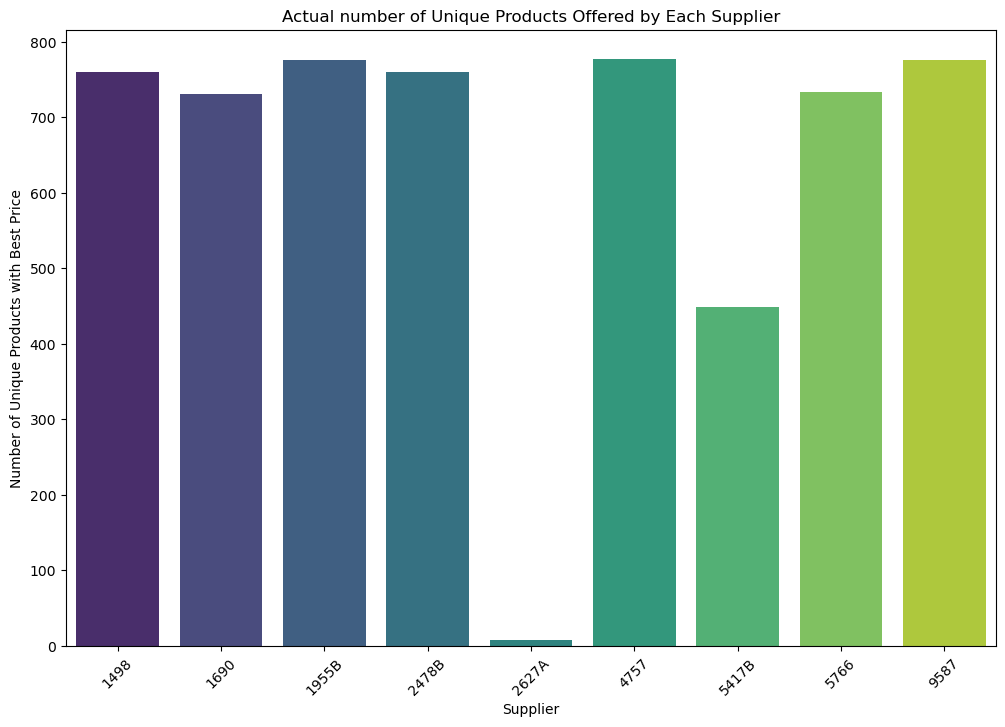

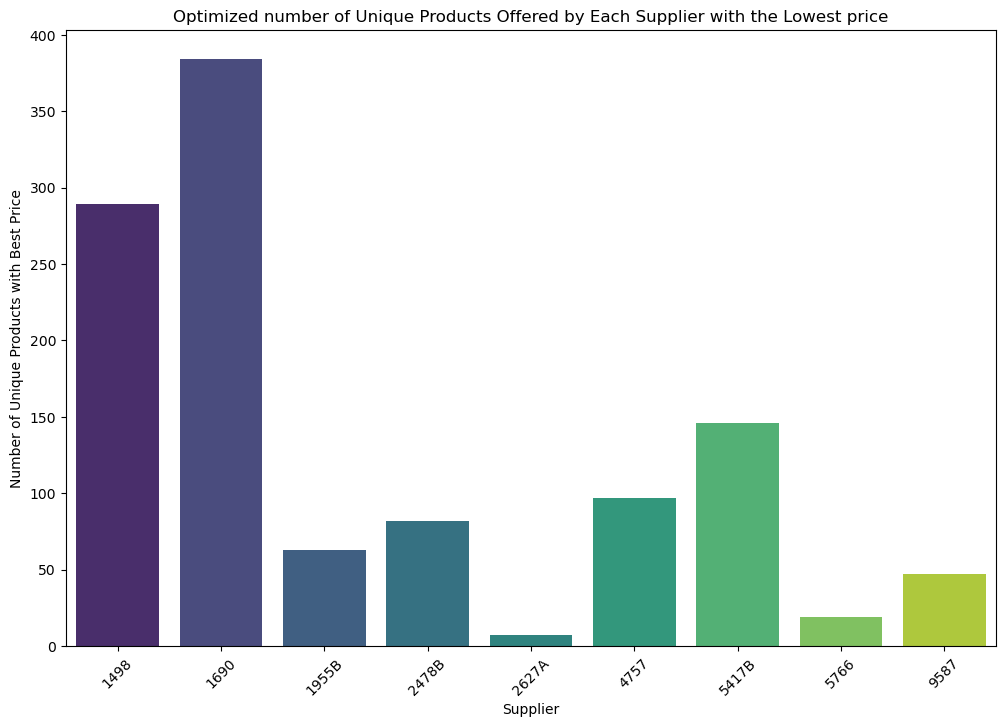

In [18]:
# Visualization 1: Suppliers with the Most Frequent Lowest Prices for various specified quantities
def plot_lowest_price_frequency(data):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=data, x='supplier', y='counts')
    plt.title('Frequency of Offering the Lowest Prices by Supplier irrespective of the specified quantity')
    plt.xlabel('Supplier')
    plt.ylabel('Count of Lowest Prices')
    plt.xticks(rotation=45)
    plt.savefig("Most_suppliers_with_lower_prices")
    plt.show()
    
# Visualization 2: Bar chart that displays the number of unique products that every supplier offers    
def plot_product_coverage_actual(data):
    # Count unique products for which each supplier offers the best price
    product_coverage = data.groupby('supplier')['product'].nunique().reset_index()
    product_coverage.columns = ['supplier', 'unique_products']
    
    # Plotting the results
    plt.figure(figsize=(12, 8))
    sns.barplot(x='supplier', y='unique_products', data=product_coverage, palette="viridis")
    plt.title('Actual number of Unique Products Offered by Each Supplier')
    plt.xlabel('Supplier')
    plt.ylabel('Number of Unique Products with Best Price')
    plt.xticks(rotation=45)
    plt.savefig('Actual_number_of_Unique_Products')
    plt.show()
    
    
# Visualization 3: Bar chart that displays the number of unique products for which each supplier offers the lowest price
def plot_product_coverage(data):
    # Count unique products for which each supplier offers the best price
    product_coverage = data.groupby('supplier')['product'].nunique().reset_index()
    product_coverage.columns = ['supplier', 'unique_products']
    
    # Plotting the results
    plt.figure(figsize=(12, 8))
    sns.barplot(x='supplier', y='unique_products', data=product_coverage, palette="viridis")
    plt.title('Optimized number of Unique Products Offered by Each Supplier with the Lowest price')
    plt.xlabel('Supplier')
    plt.ylabel('Number of Unique Products with Best Price')
    plt.xticks(rotation=45)
    plt.savefig('Optimized_number_of_Unique_Products')
    plt.show()


plot_lowest_price_frequency(supplier_scores)
plot_product_coverage_actual(prices)
plot_product_coverage(min_price_data)

### Few major Insights:

  - It should be noted that suppliers __1496__ and __1690__ offer similar product ranges. Among them, supplier __1496__ carries a larger variety of products. However, supplier __1690__ has a more extensive selection of products at the lowest prices compared to __1496__. 
  
  - In summary, across all quantity levels, supplier __1690__ offers the widest range of products at the lowest prices.

## Categories of Evaluation 

In [25]:
# 1. Best Pricing for Small Quantities (1-20 units)
small_quantity_columns = ['price_at_1', 'price_at_3', 'price_at_5', 'price_at_10', 'price_at_20']
min_price_small_quantities = min_price_data[['supplier'] + small_quantity_columns].melt(id_vars=['supplier'], var_name='quantity', value_name='price')
winner_small_quantities = min_price_small_quantities.groupby('supplier')['price'].mean().idxmin()

# 2. Best Pricing for Bulk Quantities (>50 units)
bulk_quantity_columns = ['price_at_50', 'price_at_100', 'price_at_200', 'price_at_500', 'price_at_1000']
min_price_bulk_quantities = min_price_data[['supplier'] + bulk_quantity_columns].melt(id_vars=['supplier'], var_name='quantity', value_name='price')
winner_bulk_quantities = min_price_bulk_quantities.groupby('supplier')['price'].mean().idxmin()

# 3. Broadest Product Coverage
# Count how many times each supplier offers the lowest price across all products
broadest_coverage = min_price_data.melt(id_vars=['supplier'], value_vars=[f'price_at_{q}' for q in [1, 3, 5, 10, 20, 50, 100, 200, 500, 1000]], var_name='quantity', value_name='price')
broadest_coverage_winner = broadest_coverage['supplier'].value_counts().idxmax()


# Print the winners
print("Small quantity list")
print("-------------------")
print(min_price_small_quantities.groupby('supplier')['price'].mean())
print("  ")
print("Winner for Best Pricing for Small Quantities:", winner_small_quantities)
print("__________________________________________________________")

print("  ")
print("  ")
print("Bulk quantity list")
print("-------------------")
print(min_price_bulk_quantities.groupby('supplier')['price'].mean())
print("  ")
print("Winner for Best Pricing for Bulk Quantities:", winner_bulk_quantities)
print("____________________________________________________________")

print("  ")
print("  ")
print("Winner for Broadest Product Coverage:", broadest_coverage_winner)

Small quantity list
-------------------
supplier
1498      54.290088
1690      36.236954
1955B     60.737698
2478B     44.916667
2627A     19.276471
4757      37.498487
5417B     26.296071
5766      21.525789
9587     178.258316
Name: price, dtype: float64
  
Winner for Best Pricing for Small Quantities: 2627A
__________________________________________________________
  
  
Bulk quantity list
-------------------
supplier
1498      67.500230
1690      30.598900
1955B     53.455587
2478B      3.534303
2627A     21.051667
4757      28.616303
5417B     26.057352
5766      15.079605
9587     125.745370
Name: price, dtype: float64
  
Winner for Best Pricing for Bulk Quantities: 2478B
____________________________________________________________
  
  
Winner for Broadest Product Coverage: 1690


### Result Insights:

- __For the small quantities category__: 
    - Supplier __2627A__ is not reliable because it offers only 8 different products
    - Supplier __5766__ is the best because it offers wide ranges of products (734) 
    
    
- __For the bulk quantities category__:
    - Due to uneven distribution of products and tiers, it is difficult to judge. Suppliers __2478B__ and __5766__ have shown to be the best for bulk quantities.
    
    
- __Broadest Product Coverage__:
    - Suppliers __1498__ and __1690__ win in this category
    - The reason this metric is more reliable is because of the wide variety of products and quantities that these suppliers offer